In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import wikipedia
from konlpy.tag import Kkma
from konlpy.utils import pprint
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as plb

from sklearn.decomposition import PCA

matplotlib.rc('font', family='AppleGothic')

In [2]:
key_word = u'서울'
wikipedia.set_lang('ko')
p = wikipedia.page(key_word)
sentences = p.content.split('.')
kkma = Kkma()
vocas = {}
for s in sentences:
    for word,t in kkma.pos(s):
        if t == 'NNG':
            if not vocas.has_key(word):
                vocas[word] = len(vocas)
r_vocas = dict(zip(vocas.values(), vocas.keys()))

In [3]:
vocas_map = np.identity(len(vocas))
dataset = []
for s in sentences:
    nouns = []
    for word,t in kkma.pos(s):
        if t == 'NNG':
            nouns.append(word)
    for i in range(len(nouns)):
        if i-1 >= 0:
            j1 = vocas[nouns[i]]
            j2 = vocas[nouns[i-1]]
            dataset.append(np.array([ vocas_map[j1:j1+1][0], vocas_map[j2:j2+1][0]]))
        if i+1 < len(nouns):
            j1 = vocas[nouns[i]]
            j2 = vocas[nouns[i+1]]
            dataset.append(np.array([ vocas_map[j1:j1+1][0], vocas_map[j2:j2+1][0]]))
dataset = np.array(dataset)
np.random.shuffle(dataset)

train_x = []
train_y = []
for x,y in dataset:
    train_x.append(x)
    train_y.append(y)
train_x = np.array(train_x).reshape(-1,len(vocas))
train_y = np.array(train_y).reshape(-1,len(vocas))

In [4]:
tf.reset_default_graph()
voca_size = len(vocas)
hidden_size = 100
x = tf.placeholder(dtype=tf.float32,shape=[None,voca_size])
y = tf.placeholder(dtype=tf.float32,shape=[None,voca_size])
w1 = tf.Variable(tf.random_normal(shape=[voca_size,hidden_size]))
b1 = tf.Variable(tf.zeros(shape=[1,hidden_size]))
w2 = tf.Variable(tf.random_normal(shape=[hidden_size,voca_size]))
b2 = tf.Variable(tf.zeros(shape=[1,voca_size]))
layer1 = tf.nn.relu(tf.matmul(x,w1) + b1)
layer2 = tf.nn.softmax(tf.matmul(layer1,w2) + b2)

cost = tf.reduce_mean(tf.square(-y*tf.log(layer2)))
grad = tf.train.AdamOptimizer(0.05).minimize(cost)

0.410486
0.0309316
0.0114082
0.0074799
0.00578331
0.0048773
0.00433614
0.0039945
0.0037683
0.00361427


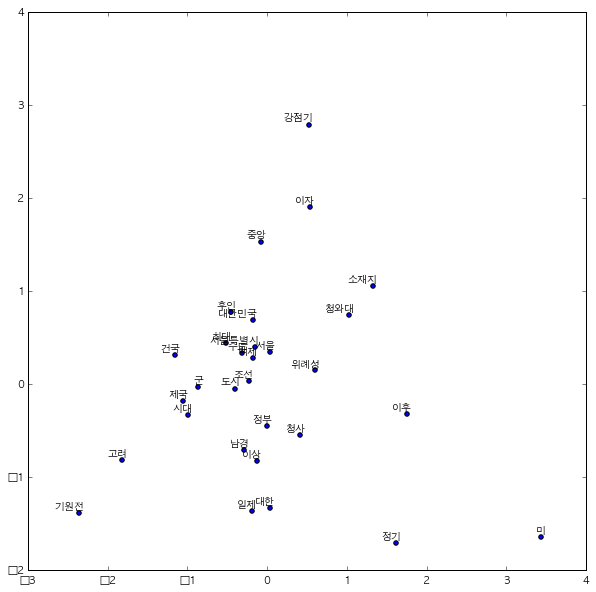

In [5]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(100):
        c,_ = sess.run([cost,grad],{x:train_x,y:train_y})
        if i % 10 == 0:
            print c
    
    plt.figure(figsize=(10,10))
    labels = []
    test_x = []
    for k in r_vocas.keys()[:30]:
        test_x.append(vocas_map[k:k+1][0])
        labels.append(r_vocas[k])
    test_x = np.array(test_x)
    
    result = sess.run(layer1,{x:test_x})
    pca = PCA(n_components=2)
    pca.fit(result)
    reduced_result = pca.transform(result)
    for i in range(len(reduced_result)):
        r = reduced_result[i]
        l = labels[i]
        plb.scatter(r[0],r[1])
        plb.annotate(l, xy=(r[0],r[1]), xytext=(5, 2), textcoords='offset points',ha='right', va='bottom')    
    